In [94]:
import numpy as np
from math import log10
import cv2
import os

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Lambda
import random

In [95]:
def resize_and_crop(image_path, output_path, new_size=256):
    img = cv2.imread(image_path)    
    height, width = img.shape[:2]

    # Get smaller edge
    mini = min(height, width)
    scale = mini / new_size

    # Resize
    img_resized = cv2.resize(img, (int(width/scale), int(height/scale)))

    new_height, new_width = img_resized.shape[:2]

    x_start = (new_width - new_size) // 2
    y_start = (new_height - new_size) // 2

    img_cropped = img_resized[y_start:y_start+new_size, x_start:x_start+new_size]
    
    cv2.imwrite(output_path, img_cropped)

def process_folder(input_folder, output_folder, new_size=256):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)
        resize_and_crop(input_path, output_path, new_size=new_size)


def cut(image_path, output_path, cut_size=3):
    img  = cv2.imread(image_path)
    h, w = img.shape[:2]
    x_start = random.randint(0, w-cut_size)
    y_start = random.randint(0, h-cut_size)
    img[y_start:y_start+cut_size, x_start:x_start+cut_size] = 0
    cv2.imwrite(output_path, img)


def prepare_impainting(input_folder, output_folder, cut_size=3, samples=10):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        
        name, ext = filename.split(os.extsep)
        for i in range(samples):
            output_path = os.path.join(output_folder, name)
            if not os.path.exists(output_path):
                os.makedirs(output_path)
            output_path = os.path.join(output_path, str(i)+os.extsep+ext)
            cut(input_path, output_path, cut_size)


# Przygotowanie danych. Oryginał -> 256x256

In [3]:
input_folder = "./data/raw/train"
output_folder = "./data/intermediate/train"
process_folder(input_folder, output_folder)

input_folder = "./data/raw/valid"
output_folder = "./data/intermediate/valid"
process_folder(input_folder, output_folder)

# 256x256 -> 32x32

In [4]:
input_folder = "./data/intermediate/train"
output_folder = "./data/scalling/train"
process_folder(input_folder, output_folder, 32)

input_folder = "./data/intermediate/valid"
output_folder = "./data/scalling/valid"
process_folder(input_folder, output_folder, 32)

## Losowe wycinanie obszaru 32x32 w 10 miejscach na każdym obrazie

In [17]:
samples = 10
cut_size = 32

input_folder = "./data/intermediate/train"
output_folder = "./data/inpainting/train"
prepare_impainting(input_folder, output_folder, cut_size=cut_size, samples=samples)

input_folder = "./data/intermediate/valid"
output_folder = "./data/inpainting/valid"
prepare_impainting(input_folder, output_folder, cut_size=cut_size, samples=samples)

# Jakieś miary

In [3]:
def SNE(img1: np.ndarray, img2: np.ndarray):
    img1_flatten, img2_flatten = img1.flatten(), img2.flatten()
    result = 0
    for pix1, pix2 in zip(img1_flatten, img2_flatten):
        result += pow(pix1-pix2, 2)
    return result

def PSNR(img1: np.ndarray, img2: np.ndarray, MAX=255):
    MSE = SNE(img1, img2) / img1.size
    return 10 * log10(pow(MAX, 2)/MSE)

def SSIM(img1: np.ndarray, img2: np.ndarray, L=255, k1=0.01, k2=0.03):
    mean1 = np.mean(img1)
    mean2 = np.mean(img2)
    var1 = np.var(img1)
    var2 = np.var(img2)
    cov = np.cov(img1, img2)
    c1 = (k1 * L) ** 2
    c2 = (k2 * L) ** 2
    return (2 * mean1 * mean2 + c1) * (2 * cov + c2) / ((pow(mean1, 2) * pow(mean2, 2) + c1) * (var1 * var2 + c2))

def LPIPS(img1: np.ndarray, img2: np.ndarray): ...
    # https://pypi.org/project/lpips/  

# Dataset

In [96]:
transform = Compose([
    Lambda(lambda x: np.array(x, dtype=np.float32) / 255.0),
    ToTensor(), # -> magicznie zmienia 32x32x3 -> 3x32x32, ale to dobrze bo tego oczekujemy
])

In [97]:
class ImageSet(Dataset):
    def __init__(self, images_folder, dest_folder, transform=None, impainting=False):
        self.folder = images_folder  # folder do obrazów  do przekształcenia (inputy)
        self.dest = dest_folder  # folder z docelowymi obrazami (outputy)
        self.images, self.dest_images = self.read_images(impainting)
        self.transform = transform

    def read_images(self, impainting=False):
        images = []
        dest_images = []
        for filename in os.listdir(self.dest):
            dest_img = cv2.imread(os.path.join(self.dest, filename))
            if impainting:
                read_folder = os.path.join(self.folder, filename.split(os.extsep)[0])
                for file in os.listdir(read_folder):
                    image_name = os.path.join(read_folder, file)
                    img = cv2.imread(image_name)
                    images.append(img)
                    dest_images.append(dest_img)
            else:
                image_name = os.path.join(self.folder, filename)
                img = cv2.imread(image_name)
                images.append(img)
                dest_images.append(dest_img)
        return images, dest_images


    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        x_image = self.images[index]
        y_image = self.dest_images[index]
        if self.transform:
            x_image = self.transform(x_image)
            y_image = self.transform(y_image)
        return x_image, y_image

# Dataset - upscalling

In [98]:
train_dataset = ImageSet("data/scalling/train", "data/intermediate/train", transform)
valid_dataset = ImageSet("data/scalling/valid", "data/intermediate/valid", transform)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)


# Dataset - inpainting

In [118]:
train_dataset = ImageSet("data/inpainting/train", "data/intermediate/train", transform, impainting=True)
valid_dataset = ImageSet("data/inpainting/valid", "data/intermediate/valid", transform, impainting=True)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Model - upscalling

In [99]:
class UpscaleCNN(nn.Module):
    def __init__(self):
        super(UpscaleCNN, self).__init__()

        # Encoder: 32x32 -> feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 32x32 -> 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 8x8 -> 4x4
            nn.ReLU(),
        )

        # Decoder: 4x4 -> 256x256 (upscaling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x16 -> 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x32 -> 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 64x64 -> 128x128
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [112]:
model = UpscaleCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Pętla uczenia

In [113]:
import tqdm

num_epochs = 30

losses = {"train":[],"val":[]}

for epoch in range(num_epochs):
    model.train()
    for x, y in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad() 
        out = model(x)
        
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {loss}")
    losses["train"].append(loss)
    with torch.no_grad():
        total_loss = 0.0
        for x, y in valid_dataset:
            out = model(x)

            loss = criterion(out, y)


            total_loss += loss.item()
        print("Validation loss:",total_loss)
    losses["val"].append(total_loss)

100%|██████████| 100/100 [00:03<00:00, 32.92it/s]


epoch #1, loss: 0.043134719133377075
Validation loss: 3.952848669141531


100%|██████████| 100/100 [00:03<00:00, 32.20it/s]


epoch #2, loss: 0.03638085350394249
Validation loss: 3.7141604917123914


100%|██████████| 100/100 [00:03<00:00, 32.35it/s]


epoch #3, loss: 0.04193704202771187
Validation loss: 3.4749061726033688


100%|██████████| 100/100 [00:03<00:00, 33.27it/s]


epoch #4, loss: 0.03562011197209358
Validation loss: 3.3206742368638515


100%|██████████| 100/100 [00:03<00:00, 31.72it/s]


epoch #5, loss: 0.0296980869024992
Validation loss: 3.1729370057582855


100%|██████████| 100/100 [00:03<00:00, 31.38it/s]


epoch #6, loss: 0.031053436920046806
Validation loss: 3.124706109985709


100%|██████████| 100/100 [00:03<00:00, 27.19it/s]


epoch #7, loss: 0.022099310532212257
Validation loss: 3.0409203255549073


100%|██████████| 100/100 [00:03<00:00, 26.07it/s]


epoch #8, loss: 0.025264078751206398
Validation loss: 3.0830306047573686


100%|██████████| 100/100 [00:06<00:00, 15.02it/s]


epoch #9, loss: 0.03617754206061363
Validation loss: 2.9853347982279956


100%|██████████| 100/100 [00:03<00:00, 25.25it/s]


epoch #10, loss: 0.03433407098054886
Validation loss: 3.020310158841312


100%|██████████| 100/100 [00:03<00:00, 25.03it/s]


epoch #11, loss: 0.03667367622256279
Validation loss: 2.985481770709157


100%|██████████| 100/100 [00:03<00:00, 26.43it/s]


epoch #12, loss: 0.04290389642119408
Validation loss: 2.958181594964117


100%|██████████| 100/100 [00:04<00:00, 24.26it/s]


epoch #13, loss: 0.029764873906970024
Validation loss: 2.929818314500153


100%|██████████| 100/100 [00:04<00:00, 24.81it/s]


epoch #14, loss: 0.025950120761990547
Validation loss: 2.9141486175358295


100%|██████████| 100/100 [00:04<00:00, 24.00it/s]


epoch #15, loss: 0.031556565314531326
Validation loss: 2.9113658033311367


100%|██████████| 100/100 [00:06<00:00, 15.71it/s]


epoch #16, loss: 0.022725120186805725
Validation loss: 2.838983601424843


100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


epoch #17, loss: 0.026379667222499847
Validation loss: 2.811942633241415


100%|██████████| 100/100 [00:03<00:00, 25.24it/s]


epoch #18, loss: 0.0236344113945961
Validation loss: 2.8246638965792954


100%|██████████| 100/100 [00:03<00:00, 25.19it/s]


epoch #19, loss: 0.02258893847465515
Validation loss: 2.8208189881406724


100%|██████████| 100/100 [00:03<00:00, 26.43it/s]


epoch #20, loss: 0.029724327847361565
Validation loss: 2.791247864253819


100%|██████████| 100/100 [00:03<00:00, 25.37it/s]


epoch #21, loss: 0.028194500133395195
Validation loss: 2.7933590980246663


100%|██████████| 100/100 [00:03<00:00, 25.69it/s]


epoch #22, loss: 0.030233463272452354
Validation loss: 2.7859389651566744


100%|██████████| 100/100 [00:03<00:00, 25.43it/s]


epoch #23, loss: 0.030862323939800262
Validation loss: 2.8089155899360776


100%|██████████| 100/100 [00:06<00:00, 15.18it/s]


epoch #24, loss: 0.026505418121814728
Validation loss: 2.7913088998757303


100%|██████████| 100/100 [00:03<00:00, 25.52it/s]


epoch #25, loss: 0.025926141068339348
Validation loss: 2.5002460083924234


100%|██████████| 100/100 [00:03<00:00, 25.83it/s]


epoch #26, loss: 0.02003592438995838
Validation loss: 2.4027016567997634


100%|██████████| 100/100 [00:04<00:00, 24.73it/s]


epoch #27, loss: 0.02175559289753437
Validation loss: 2.392829038668424


100%|██████████| 100/100 [00:04<00:00, 23.69it/s]


epoch #28, loss: 0.017523517832159996
Validation loss: 2.4099990385584533


100%|██████████| 100/100 [00:03<00:00, 27.32it/s]


epoch #29, loss: 0.020419703796505928
Validation loss: 2.3458098233677447


100%|██████████| 100/100 [00:04<00:00, 23.59it/s]


epoch #30, loss: 0.022620419040322304
Validation loss: 2.3695728816092014


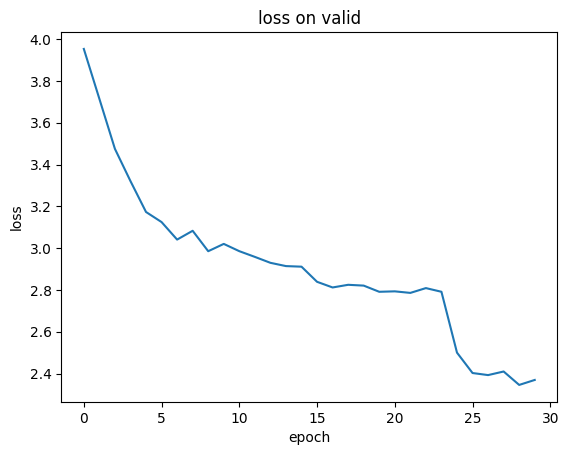

In [114]:
x = range(num_epochs)
y = losses['val']

plt.plot(x, y)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("loss on valid")
plt.show()

In [21]:
def denormalize(image: np.ndarray) -> np.ndarray:
    image = image * 255
    return image.clip(0, 255).astype(np.uint8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.058042392..0.99367785].


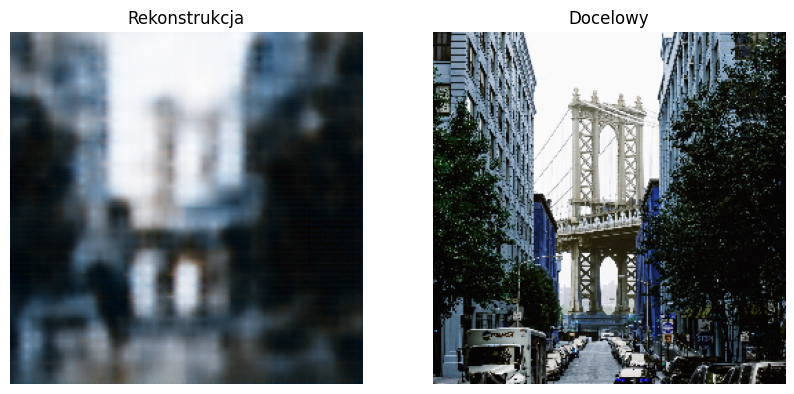

In [117]:
a = random.choice(valid_dataset)

model.eval()

out = model(a[0])
out = out.permute(1, 2, 0).detach().numpy()
# out = denormalize(out)  # na liczbach z przedziału (0, 1) też jakoś wyświetla więc nie trzeba denormalize

dest = a[1].permute(1, 2, 0).detach().numpy()
# dest = denormalize(dest)

fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 

axes[0].imshow(out)
axes[0].axis('off')
axes[0].set_title("Rekonstrukcja")

axes[1].imshow(dest)
axes[1].axis('off')
axes[1].set_title("Docelowy")

plt.show()

# Model - Inpainting

In [119]:
class InpaintingCNN(nn.Module):
    def __init__(self):
        super(InpaintingCNN, self).__init__()

        # **Encoder** (Ekstrakcja cech)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  # 256 -> 128
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), # 128 -> 64
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), # 64 -> 32
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), # 32 -> 16
            nn.ReLU()
        )

        # **Decoder** (Rekonstrukcja obrazu)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1), # 16 -> 32
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 32 -> 64
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1), # 64 -> 128
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, stride=2, padding=1, output_padding=1), # 128 -> 256
            nn.Sigmoid()  # Sigmoid, bo chcemy wartości w zakresie 0-1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [120]:
model = InpaintingCNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Pętla uczenia

In [123]:
num_epochs = 50

losses = {"train":[],"val":[]}

model = model.to(device)

In [124]:
import tqdm


for epoch in range(num_epochs):
    model.train()
    for x, y in tqdm.tqdm(train_dataloader):
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)

        out = model(x)
        
        loss = criterion(out, y)

        loss.backward()
        optimizer.step()
    
    model.eval()
    print(f"epoch #{epoch+1}, loss: {loss}")
    losses["train"].append(loss)
    with torch.no_grad():
        total_loss = 0.0
        for x, y in valid_dataset:
            x, y = x.to(device), y.to(device)

            out = model(x)

            loss = criterion(out, y)


            total_loss += loss.item()
        print("Validation loss:",total_loss)
    losses["val"].append(total_loss)

100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #1, loss: 0.014875968918204308
Validation loss: 13.975096172420308


100%|██████████| 500/500 [01:17<00:00,  6.43it/s]


epoch #2, loss: 0.00938788615167141
Validation loss: 11.150938051287085


100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #3, loss: 0.009527171030640602
Validation loss: 9.773242259048857


100%|██████████| 500/500 [01:15<00:00,  6.64it/s]


epoch #4, loss: 0.00799048412591219
Validation loss: 9.397230172762647


100%|██████████| 500/500 [01:18<00:00,  6.40it/s]


epoch #5, loss: 0.006993616931140423
Validation loss: 8.127633397351019


100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


epoch #6, loss: 0.007518719416111708
Validation loss: 7.625287810456939


100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #7, loss: 0.00691722147166729
Validation loss: 7.4180940120713785


100%|██████████| 500/500 [01:14<00:00,  6.69it/s]


epoch #8, loss: 0.006334719713777304
Validation loss: 6.996242277033161


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


epoch #9, loss: 0.0066278669983148575
Validation loss: 6.934412005124614


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #10, loss: 0.0068802423775196075
Validation loss: 6.441866649372969


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


epoch #11, loss: 0.008587022311985493
Validation loss: 7.016604944714345


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #12, loss: 0.004822201561182737
Validation loss: 5.909229674260132


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #13, loss: 0.004794859327375889
Validation loss: 5.601856654451694


100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


epoch #14, loss: 0.0059436834417283535
Validation loss: 5.495689537783619


100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


epoch #15, loss: 0.005142510868608952
Validation loss: 5.292448508494999


100%|██████████| 500/500 [01:16<00:00,  6.56it/s]


epoch #16, loss: 0.003836941672489047
Validation loss: 5.200356080371421


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #17, loss: 0.003887852653861046
Validation loss: 5.018987385323271


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #18, loss: 0.004476451780647039
Validation loss: 4.8669565069139935


100%|██████████| 500/500 [01:16<00:00,  6.55it/s]


epoch #19, loss: 0.004425495862960815
Validation loss: 4.938401966006495


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #20, loss: 0.0046401433646678925
Validation loss: 4.762069728632923


100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


epoch #21, loss: 0.004226816352456808
Validation loss: 4.6575964475632645


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #22, loss: 0.005255686119198799
Validation loss: 4.488514553580899


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #23, loss: 0.003516674740239978
Validation loss: 4.381728867680067


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #24, loss: 0.003781443228945136
Validation loss: 5.069593637716025


100%|██████████| 500/500 [01:13<00:00,  6.77it/s]


epoch #25, loss: 0.0050492603331804276
Validation loss: 4.523876943509094


100%|██████████| 500/500 [01:13<00:00,  6.76it/s]


epoch #26, loss: 0.004080020822584629
Validation loss: 4.027420067694038


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #27, loss: 0.0051756929606199265
Validation loss: 4.092975458159344


100%|██████████| 500/500 [01:14<00:00,  6.76it/s]


epoch #28, loss: 0.0037470320239663124
Validation loss: 4.081340834120056


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #29, loss: 0.003562608268111944
Validation loss: 4.078272964456119


100%|██████████| 500/500 [01:14<00:00,  6.68it/s]


epoch #30, loss: 0.0032448354177176952
Validation loss: 3.8548146774992347


100%|██████████| 500/500 [01:14<00:00,  6.75it/s]


epoch #31, loss: 0.0034355479292571545
Validation loss: 3.7781759127101395


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #32, loss: 0.002761242678388953
Validation loss: 3.6051629633293487


100%|██████████| 500/500 [01:14<00:00,  6.74it/s]


epoch #33, loss: 0.0030639120377600193
Validation loss: 3.674170746380696


100%|██████████| 500/500 [01:18<00:00,  6.38it/s]


epoch #34, loss: 0.002826635492965579
Validation loss: 3.5382753570447676


100%|██████████| 500/500 [01:17<00:00,  6.49it/s]


epoch #35, loss: 0.003707675961777568
Validation loss: 3.6516676847822964


100%|██████████| 500/500 [01:16<00:00,  6.55it/s]


epoch #36, loss: 0.004636027384549379
Validation loss: 3.626757384627126


100%|██████████| 500/500 [01:19<00:00,  6.31it/s]


epoch #37, loss: 0.003768094815313816
Validation loss: 3.4925216521369293


100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


epoch #38, loss: 0.0034427400678396225
Validation loss: 3.4966582943161484


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


epoch #39, loss: 0.003004565369337797
Validation loss: 3.3397697648906615


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


epoch #40, loss: 0.0030964831821620464
Validation loss: 3.257893729576608


100%|██████████| 500/500 [01:15<00:00,  6.60it/s]


epoch #41, loss: 0.0028854934498667717
Validation loss: 3.283588926802622


100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #42, loss: 0.0029895592015236616
Validation loss: 3.3092782791354693


100%|██████████| 500/500 [01:14<00:00,  6.71it/s]


epoch #43, loss: 0.002839833265170455
Validation loss: 3.3153540894854814


100%|██████████| 500/500 [01:18<00:00,  6.41it/s]


epoch #44, loss: 0.0032701431773602962
Validation loss: 3.52057736372808


100%|██████████| 500/500 [01:14<00:00,  6.67it/s]


epoch #45, loss: 0.0030109770596027374
Validation loss: 3.061563468509121


100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #46, loss: 0.002691299421712756
Validation loss: 3.1536324919725303


100%|██████████| 500/500 [01:15<00:00,  6.65it/s]


epoch #47, loss: 0.0027417195960879326
Validation loss: 3.0613781686406583


100%|██████████| 500/500 [01:15<00:00,  6.63it/s]


epoch #48, loss: 0.002773641375824809
Validation loss: 3.0150983948551584


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


epoch #49, loss: 0.002818513195961714
Validation loss: 2.981754607259063


100%|██████████| 500/500 [01:15<00:00,  6.66it/s]


epoch #50, loss: 0.0026456317864358425
Validation loss: 2.941547729249578


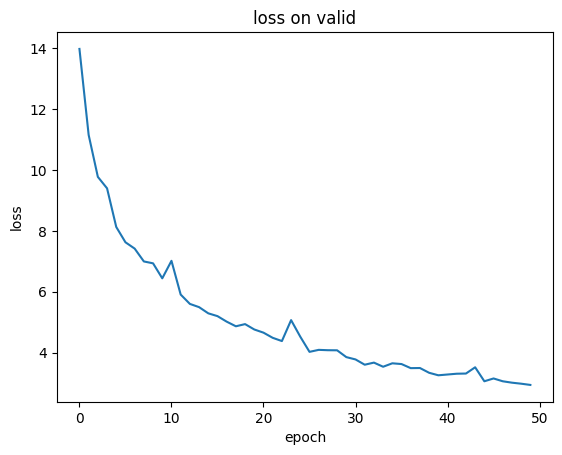

In [125]:
x = range(num_epochs)
y = losses['val']

plt.plot(x, y)
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("loss on valid")
plt.show()

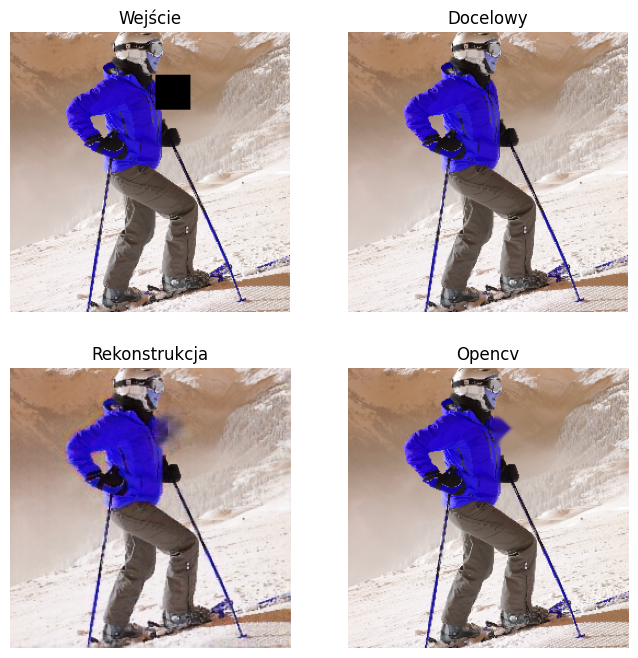

In [187]:
a = random.choice(valid_dataset)
# a = valid_dataset[25]
model.eval()

out = model(a[0].to(device))
out = out.permute(1, 2, 0).detach().cpu().numpy()
# out = denormalize(out)  # na liczbach z przedziału (0, 1) też jakoś wyświetla więc nie trzeba denormalize

dest = a[1].permute(1, 2, 0).detach().numpy()
input = a[0].permute(1, 2, 0).detach().numpy()


black_mask = (np.all(input < 0.05, axis=2)).astype(np.uint8) * 255
image_uint8 = (input * 255).astype(np.uint8)
out1 = cv2.inpaint(image_uint8, black_mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
# dest = denormalize(dest)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

axes[0, 0].imshow(input)
axes[0, 0].axis('off')
axes[0, 0].set_title("Wejście")

axes[0, 1].imshow(dest)
axes[0, 1].axis('off')
axes[0, 1].set_title("Docelowy")

axes[1, 0].imshow(out)
axes[1, 0].axis('off')
axes[1, 0].set_title("Rekonstrukcja")

axes[1, 1].imshow(out1)
axes[1, 1].axis('off')
axes[1, 1].set_title("Opencv")

plt.show()

In [185]:
torch.save(model, "model_inpainting.pth")

In [186]:
model = torch.load("model_inpainting.pth", weights_only=False)
model.eval()

InpaintingCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (7): Sigmoid()
  )
)